<a href="https://colab.research.google.com/github/turab45/mastering-pytorch-and-pytorch-lightining-/blob/master/DCGAN_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

print("GPU Available: {}".format(torch.cuda.is_available()))

GPU Available: True


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
class Discriminator(nn.Module):
  def __init__(self, img_dim, features_d):
    super(Discriminator, self).__init__()

    self.disc = nn.Sequential(
        # Input: N x img_dim x 64 x 64
        nn.Conv2d(img_dim, features_d, kernel_size=4, stride=2, padding=1), #32x32
        nn.LeakyReLU(0.2),
        self._block(features_d, features_d*2, 4, 2, 1), #16x16
        self._block(features_d*2, features_d*4, 4, 2, 1), #8x8
        self._block(features_d*4, features_d*8, 4, 2, 1), #4x4
        nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0), #1x1
        nn.Sigmoid(),
    )


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False, # because we use the BatchNorm
        ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.disc(x)


class Generator(nn.Module):
  def __init__(self, z_dim, channels_img, features_g):
    super(Generator, self).__init__()

    self.gen = nn.Sequential(
        # Input: N x z_dim x 1x1
        self._block(z_dim, features_g*16, 4, 1, 0), # N x features_g*16 x 4 x 4
        self._block(features_g*16, features_g*8, 4, 2, 1), # 8x8
        self._block(features_g*8, features_g*4, 4, 2, 1), # 16x16
        self._block(features_g*4, features_g*2, 4, 2, 1), #32x32
        nn.ConvTranspose2d(
            features_g*2,
            channels_img,
            kernel_size=4,
            stride=2,
            padding=1,
        ),
        nn.Tanh(), # [-1, 1]
    )


  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            bias=False,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(0.2),
    )

  def forward(self, x):
    return self.gen(x)


def initialize_weights(model):
  for m in model.modules():
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
      nn.init.normal_(m.weight.data, 0.0, 0.02)

In [13]:
def test():
  N, in_channels, H, W=8,3,64,64
  z_dim=100
  x=torch.randn((N, in_channels, H, W))
  disc = Discriminator(in_channels, 8)
  initialize_weights(disc)
  assert disc(x).shape == (N, 1,1,1)

  gen = Generator(z_dim, in_channels, 8)
  z = torch.randn((N, z_dim, 1,1))
  initialize_weights(gen)
  assert gen(z).shape == (N, in_channels, H, W)
  print("Success")

test()

Success


In [14]:
#Hyperparameters
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNEL_IMG = 1
NOISE_DIM = 100
Z_DIM = 100
NUM_EPOCHS = 5
FEATURES_GEN = 64
FEATURES_DISC = 64

transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNEL_IMG)], [0.5 for _ in range(CHANNEL_IMG)]
        ),
    ]
)

In [15]:
# If you train on MNIST, remember to set channels_img to 1
dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms, download=True
)

# comment mnist above and uncomment below if train on CelebA
# dataset = datasets.ImageFolder(root="celeb_dataset", transform=transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# # Plot some training images
# real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Training Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [16]:
gen = Generator(NOISE_DIM, CHANNEL_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNEL_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [17]:
fixed_noise = torch.randn(64, NOISE_DIM, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

In [19]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(NUM_EPOCHS):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        disc.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = disc(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, NOISE_DIM, 1, 1, device=device)
        # Generate fake image batch with G
        fake = gen(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = disc(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        opt_disc.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        gen.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = disc(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        opt_gen.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, NUM_EPOCHS, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == NUM_EPOCHS-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = gen(fixed_noise).detach()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/469]	Loss_D: 1.2890	Loss_G: 0.8455	D(x): 0.5108	D(G(z)): 0.4605 / 0.4294
[0/5][50/469]	Loss_D: 0.1037	Loss_G: 2.9459	D(x): 0.9540	D(G(z)): 0.0550 / 0.0526
[0/5][100/469]	Loss_D: 0.0295	Loss_G: 4.1353	D(x): 0.9876	D(G(z)): 0.0168 / 0.0162
[0/5][150/469]	Loss_D: 0.0141	Loss_G: 4.8615	D(x): 0.9940	D(G(z)): 0.0081 / 0.0078
[0/5][200/469]	Loss_D: 1.1286	Loss_G: 0.9151	D(x): 0.5756	D(G(z)): 0.4361 / 0.4007
[0/5][250/469]	Loss_D: 0.9314	Loss_G: 1.3007	D(x): 0.5043	D(G(z)): 0.2089 / 0.2783
[0/5][300/469]	Loss_D: 1.2951	Loss_G: 0.9907	D(x): 0.3680	D(G(z)): 0.2369 / 0.3758
[0/5][350/469]	Loss_D: 0.8764	Loss_G: 1.9208	D(x): 0.6670	D(G(z)): 0.3688 / 0.1499
[0/5][400/469]	Loss_D: 1.1735	Loss_G: 0.8534	D(x): 0.4892	D(G(z)): 0.3458 / 0.4339
[0/5][450/469]	Loss_D: 1.1443	Loss_G: 0.9483	D(x): 0.5685	D(G(z)): 0.4293 / 0.3937
[1/5][0/469]	Loss_D: 1.2306	Loss_G: 0.9918	D(x): 0.5730	D(G(z)): 0.4792 / 0.3790
[1/5][50/469]	Loss_D: 1.2466	Loss_G: 0.8611	D(x): 0.5173	D(G(z)): 

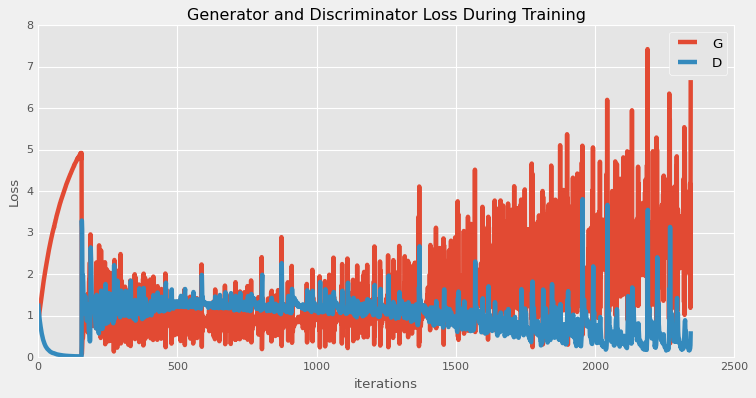

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
# plt.style.use('ggplot')

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

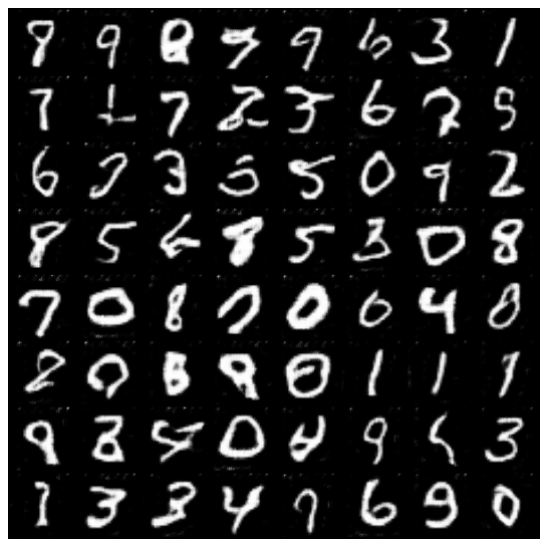

In [30]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i.cpu(),(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

#saving as video
# writervideo = animation.FFMpegWriter(fps=60)
# ani.save('increasingStraightLine.mp4', writer=writervideo)


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=logs